# 0. Content

1. Exploratory Data Analysis

    - Importing data and necessary modules
    - Visualization of input data


2. Data Preprocessing

    - Identification of certain areas
    - Filling empty areas (Oversampling)
    - Plot new training data


3. Model training and hyperparameter tuning

    - K-nearest neighbor classification
    - Comparison with other models

# 1. Exploratory Data Analysis

### 1.1 Importing data and necessary modules

First, let's import necessary modules for data analysis and visualization along with tools for data preprocessing.

In [658]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

Now let's import training data, and check it's main charasteristics like shape, number of missing values, etc.

In [310]:
df = pd.read_csv('data/train.csv', index_col='id')
df.head()

,x,y,c
id,,,
0,1477,574,1
1,933,1623,0
2,1351,254,1
3,318,499,1
4,619,1470,0


In [4]:
df.shape

(311057, 3)

In [654]:
df.isna().sum()

x    0
y    0
c    0
dtype: int64

### 1.2 Visualization of input data

Let's visualize our picture, by plotting ONES and ZEROS separately and check which parts of picture are missing.

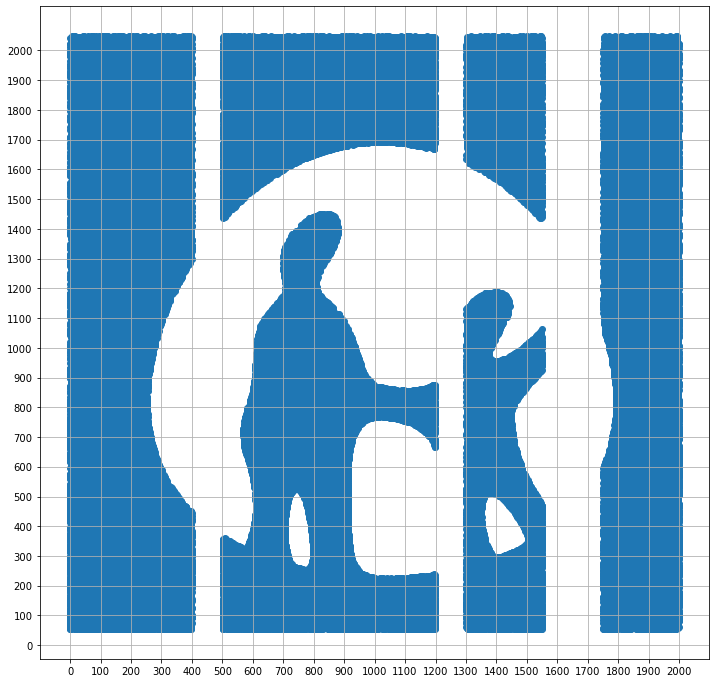

In [635]:
plt.figure(figsize=[12,12])
plt.scatter(df[df['c'] == 1]['x'], df[df['c'] == 1]['y'])
ticks = np.arange(0, 2050, 100)
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid()

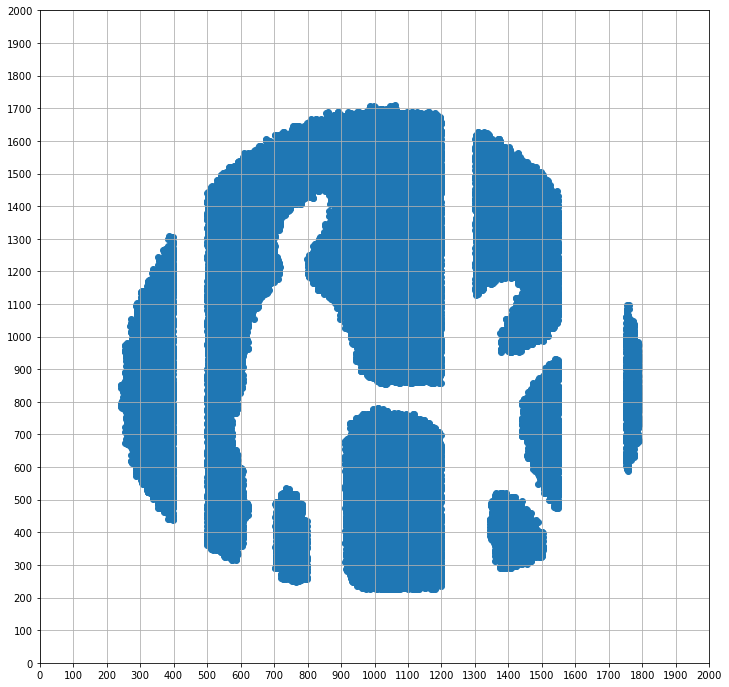

In [636]:
plt.figure(figsize=[12,12])
plt.scatter(df[df['c'] == 0]['x'], df[df['c'] == 0]['y'])
ticks = np.arange(0, 2050, 100)
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid()

# 2. Data preprocessing

### 2.1 Identification of certain areas

From the pictures above, we can see that we should reconstruct the logo image of Kaspi. We can also see, that some areas of image are absent (for instance: 400 < x < 500, 1200 < x < 1300). We can also say, that we can fill them with ONES and ZEROS and make no mistake, and such filling will increase the efficiency of our algorithm. Let's indentify all such areas and plot them to see if we did it correctly.

In [647]:
ones = {
        (400, 500): [(50, 365), (1435, 2050)],
        (1200, 1300): [(50, 235), (660, 880), (1670, 2050)],
        (1550, 1610): [(1000, 1060)],
        (1550, 1750): [(50, 390), (1430, 2050)]
       }

zeros = {
         (400, 500): [(440, 1305)],
         (1200, 1240): [(350, 450)],
         (1200, 1300): [(1125, 1625)],
         (1550, 1750): [(585, 930)],
         (1550, 1600): [(470, 585)],
         (1550, 1600): [(470, 585)],
         (1550, 1630): [(1180, 1250)],
         (1600, 1700): [(550, 585)],
         (1650, 1750): [(930, 1100)]
        }

Red areas points value: 1
Green areas points value: 0


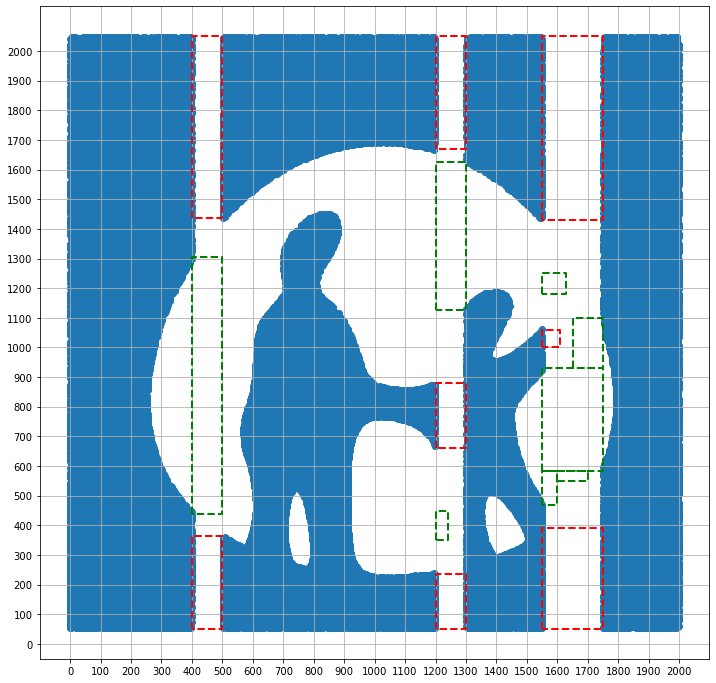

In [648]:
fig = plt.figure(figsize=[12,12])
plt.scatter(df[df['c'] == 1]['x'], df[df['c'] == 1]['y'])
ticks = np.arange(0, 2050, 100)
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid()

for key, value in ones.items():
    pnts = []
    for val in value:
        pnts = np.array([[key[0], val[0]], [key[0], val[1]], [key[1], val[1]], [key[1], val[0]], [key[0], val[0]]])
        plt.plot(pnts[:, 0], pnts[:, 1], 'k--', c='r', lw=2, label='Points value: 1')
        
        #plt.legend(['Points value: 1'])
        
for key, value in zeros.items():
    pnts = []
    for val in value:
        pnts = np.array([[key[0], val[0]], [key[0], val[1]], [key[1], val[1]], [key[1], val[0]], [key[0], val[0]]])
        plt.plot(pnts[:, 0], pnts[:, 1], 'k--', c='g', lw=2, label='Points value: 0')
        
print('Red areas points value:', 1)
print('Green areas points value:', 0)

### 2.2 Filling empty areas (Oversampling)

Now we know which areas we should fill with the values. We know for sure that they should be filled either with ONES or ZEROS. To do so, let's use the following procedure:

1) Calculate average density of points on each on x-axis: avg_points_x = total_points / image_width

2) Run the cycle and calculate number of point for each area: avg_points_area = avg_points_x * area_width * area_height / total_height

3) Concatenate new data with initial training data

In [649]:
density_x = df.shape[0] / (2000 - (100 + 100 + 200)) # widths of empty zones
density_x

194.410625

In [650]:
temp_dfs = []
for key, values in ones.items():
    for val in values:
        num_of_points = (val[1] - val[0]) / 2000 * density_x * (key[1] - key[0])
        x_s = np.random.randint(key[0], key[1], int(num_of_points))
        y_s = np.random.randint(val[0], val[1], int(num_of_points))
        c_s = [1] * int(num_of_points)
        os_points = zip(x_s, y_s, c_s)
        df_temp = pd.DataFrame(os_points, columns =['x', 'y', 'c'])
        temp_dfs.append(df_temp)

for key, values in zeros.items():
    for val in values:
        num_of_points = (val[1] - val[0]) / 2000 * density_x * (key[1] - key[0])
        x_s = np.random.randint(key[0], key[1], int(num_of_points))
        y_s = np.random.randint(val[0], val[1], int(num_of_points))
        c_s = [0] * int(num_of_points)
        os_points = zip(x_s, y_s, c_s)
        df_temp = pd.DataFrame(os_points, columns =['x', 'y', 'c'])
        temp_dfs.append(df_temp)
        
df_os = pd.concat(temp_dfs)
df_os.shape

(59136, 3)

In [651]:
df_upd = [df]
df_upd.append(df_os)
df_upd = pd.concat(df_upd)
df_upd.reset_index(drop=True, inplace=True)

### 2.3 Plot new training data

Now let's see how we changed our training dataset. Let's plot ZEROS and ONES separately once again and see the result of oversampling.

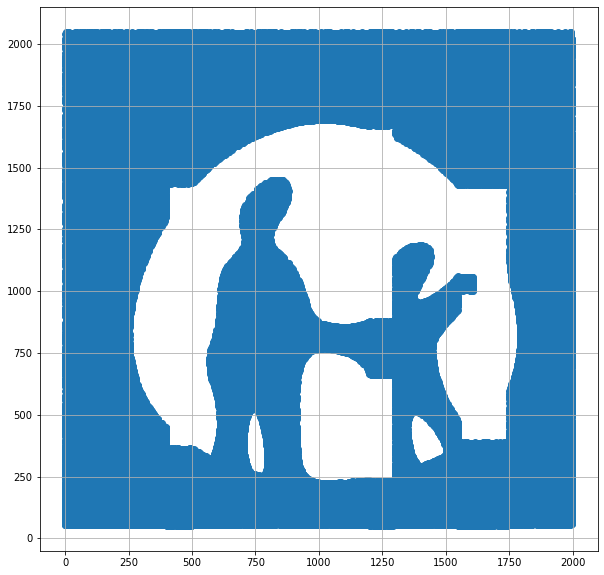

In [652]:
plt.figure(figsize=[10,10])
plt.scatter(df_upd[df_upd['c'] == 1]['x'], df_upd[df_upd['c'] == 1]['y'])
plt.grid()

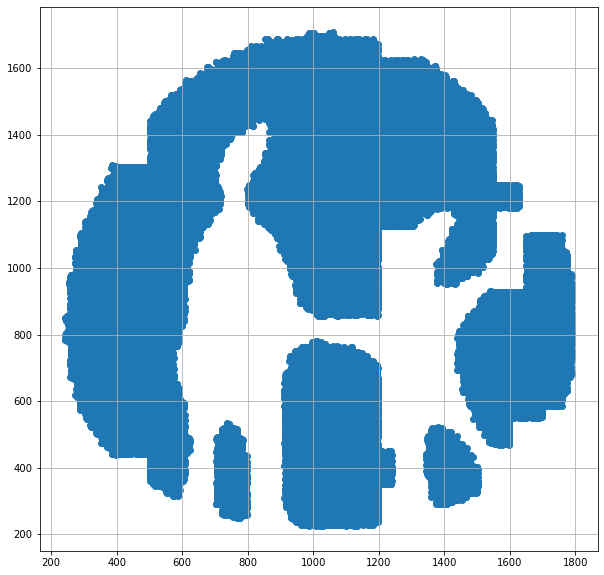

In [653]:
plt.figure(figsize=[10,10])
plt.scatter(df_upd[df_upd['c'] == 0]['x'], df_upd[df_upd['c'] == 0]['y'])
plt.grid()

### Data scaling pipeline

Now, let's prepare pipelines for scaling our data using standard scaler. 

In [714]:
scale_pipe = make_pipeline(StandardScaler())
column_transformer = ColumnTransformer([('scaling', scale_pipe, ['x', 'y'])], remainder='passthrough')
column_transformer_lr = ColumnTransformer([('scaling', scale_pipe, ['x', 'y', 'x^2', 'y^2', 'x^y'])], remainder='passthrough')

# 3. Model training and hyperparameter tuning

### 3.1 K-nearest neighbors classification

Let's train K-nearest neighbor classification model, as it intuitively seems to be most relevant algorithm to solve our problem. First we prepare all necessary pipelines and parameter grid, to find best the hyperparameters.

In [663]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline([('column_transformer', column_transformer),
                    ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': [3, 5, 10, 20],
              'knn__weights' : ['uniform', 'distance'],
              'knn__algorithm': ['ball_tree', 'kd_tree'],
              'knn__leaf_size': [15, 30, 50],
              'knn__p': [1, 2]
             }

knn_grid = GridSearchCV(knn_pipe, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
knn_grid.fit(df_upd.drop(['c'], axis=1), df_upd['c'])

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.110, total=   2.5s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.107, total=   3.1s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.110, total=   3.0s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.103, total=   3.0s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.119, total=   2.9s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=distance, score=-0.108, total=   0.9s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbo

[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=5, knn__p=2, knn__weights=distance, score=-0.100, total=   0.9s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=5, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=5, knn__p=2, knn__weights=distance, score=-0.116, total=   0.8s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, score=-0.112, total=   3.0s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, score=-0.112, total=   3.1s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_ne

[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=uniform, score=-0.109, total=   3.3s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=uniform, score=-0.122, total=   3.2s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=distance, score=-0.106, total=   1.4s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=distance, score=-0.105, total=   1.3s
[CV] knn__algorithm=ball_tree, knn__leaf_size=15, knn__n_neighbors=20, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=15, knn_

[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=1, knn__weights=distance, score=-0.100, total=   0.9s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=1, knn__weights=distance, score=-0.115, total=   0.9s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=uniform, score=-0.112, total=   3.0s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=uniform, score=-0.110, total=   2.9s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbo

[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=uniform, score=-0.107, total=   5.0s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=uniform, score=-0.132, total=   4.3s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=distance, score=-0.105, total=   2.1s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=distance, score=-0.105, total=   2.1s
[CV] knn__algorithm=ball_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=30, knn_

[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=3, knn__p=2, knn__weights=distance, score=-0.101, total=   1.0s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=3, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=3, knn__p=2, knn__weights=distance, score=-0.115, total=   1.2s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=uniform, score=-0.111, total=   6.8s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=uniform, score=-0.108, total=   4.3s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbo

[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=uniform, score=-0.110, total=   4.2s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=uniform, score=-0.115, total=   4.5s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=distance, score=-0.107, total=   1.6s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=distance, score=-0.106, total=   1.5s
[CV] knn__algorithm=ball_tree, knn__leaf_size=50, knn__n_neighbors=10, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=ball_tree, knn__leaf_size=50, knn_

[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=distance, score=-0.099, total=   0.8s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=1, knn__weights=distance, score=-0.119, total=   0.8s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=2, knn__weights=uniform, score=-0.111, total=   3.7s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=2, knn__weights=uniform, score=-0.107, total=   3.5s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=3, knn__p=2, kn

[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=uniform, score=-0.118, total=   3.9s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=distance, score=-0.106, total=   0.7s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=distance, score=-0.104, total=   0.7s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=distance, score=-0.105, total=   0.7s
[CV] knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=15, knn__n_neighbors=10,

[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.110, total=   2.7s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.107, total=   2.7s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.110, total=   2.8s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform, score=-0.103, total=   2.9s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=3, knn__p=1, knn__

[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=distance, score=-0.105, total=   0.9s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=distance, score=-0.106, total=   1.3s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=distance, score=-0.100, total=   1.3s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=5, knn__p=2, knn__weights=distance, score=-0.116, total=   1.2s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=10, knn__p=1, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=10, knn__p

[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=uniform, score=-0.112, total=   3.9s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=uniform, score=-0.109, total=   3.5s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=uniform, score=-0.122, total=   3.3s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=distance, score=-0.106, total=   1.1s
[CV] knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn__p=2, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=30, knn__n_neighbors=20, knn

[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=distance, score=-0.100, total=   0.8s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=1, knn__weights=distance, score=-0.115, total=   1.0s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=2, knn__weights=uniform, score=-0.112, total=   3.7s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=2, knn__weights=uniform, score=-0.110, total=   3.5s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=2, knn__weights=uniform 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=5, knn__p=2, kn

[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=uniform, score=-0.132, total=   3.3s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=distance, score=-0.105, total=   1.1s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=distance, score=-0.105, total=   1.0s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=distance, score=-0.106, total=   1.0s
[CV] knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20, knn__p=1, knn__weights=distance 
[CV]  knn__algorithm=kd_tree, knn__leaf_size=50, knn__n_neighbors=20,

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 18.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['x',
                                                                          'y'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__algorithm': ['ball_tree', 'kd_tree'],
                         'knn__leaf_size': [15, 30, 50],
                         'knn__n_neighbors': [3, 5, 10, 20], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='ne

In [664]:
knn_best = knn_grid.best_estimator_.fit(df_upd.drop(['c'], axis=1), df_upd['c'])

In [678]:
print(knn_grid.best_score_)

-0.1058778196119691


In [721]:
print(knn_grid.best_estimator_)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['x', 'y'])])),
                ('knn',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=10,
                                      p=1, weights='distance'))])


Now let's get test data and use the best KNN classificator to predict values of test data.

In [665]:
df_test = pd.read_csv('data/test.csv', index_col='id')
y_test_predict = knn_best.predict(df_test)

Let's plot our predicitions to check if they are visually looking correct

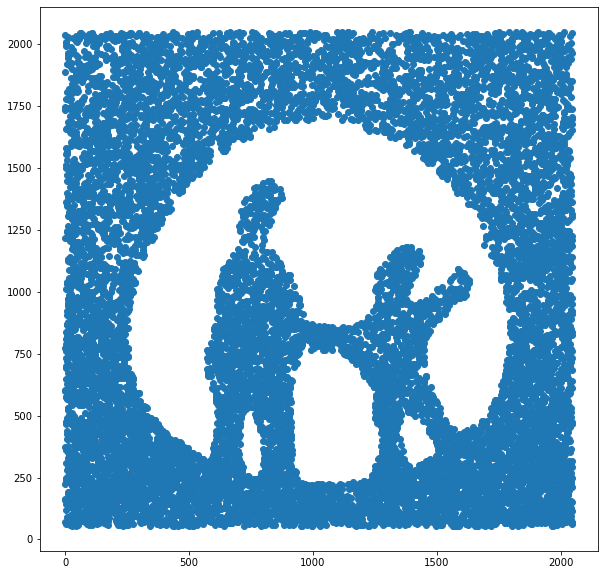

In [666]:
df_test_full = df_test.copy()
df_test_full['c'] = y_test_predict
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 1]['x'], df_test_full[df_test_full['c'] == 1]['y'])

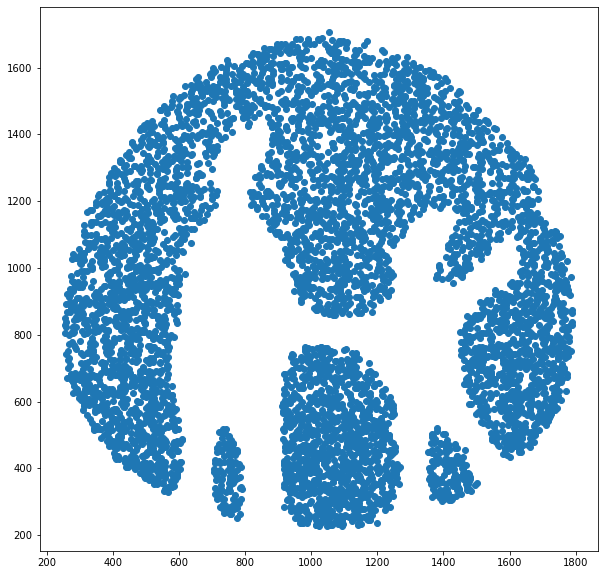

In [667]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 0]['x'], df_test_full[df_test_full['c'] == 0]['y'])

Finally, let's make Kaggle submission file

In [668]:
y_test_predict = pd.Series(df_test_full['c'])
sub_pred = pd.DataFrame()
sub_pred['id'] = y_test_predict.index
sub_pred['c'] = y_test_predict.values.astype('int')
sub_pred.index = sub_pred['id']
sub_pred.drop(columns=['id'], inplace=True)
sub_pred.to_csv('kaspi_preds.csv')

### 3.2 Comparison with other models

I tried to use other algorithms for classification, but they didn't perform better than KNN. Below results for several other algorithms.

#### Logistic Regression

In [715]:
from sklearn.linear_model import LogisticRegression

lr_pipe = Pipeline([('column_transformer_lr', column_transformer_lr),
                    ('lr', LogisticRegression())])

param_grid = {'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'lr__C' : [0.2, 0.5, 1, 2, 5],
             }

df_upd_lr = df_upd.copy()
df_upd_lr['x^2'] = df_upd_lr['x'] ** 2
df_upd_lr['y^2'] = df_upd_lr['y'] ** 2
df_upd_lr['x^y'] = df_upd_lr['x'] * df_upd_lr['y']
lr_grid = GridSearchCV(lr_pipe, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
lr_grid.fit(df_upd_lr.drop(['c'], axis=1), df_upd_lr['c'])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] lr__C=0.2, lr__penalty=l1 .......................................
[CV] ............. lr__C=0.2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=l1 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' p

[CV] ............. lr__C=0.2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=l1 .......................................
[CV] ............. lr__C=0.2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=l1 .......................................
[CV] ............. lr__C=0.2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=l1 .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............. lr__C=0.2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.2, lr__penalty=l2, score=-0.495, total=   0.8s
[CV] lr__C=0.2, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.2, lr__penalty=l2, score=-0.498, total=   0.8s
[CV] lr__C=0.2, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.2, lr__penalty=l2, score=-0.495, total=   0.7s
[CV] lr__C=0.2, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.2, lr__penalty=l2, score=-0.495, total=   0.7s
[CV] lr__C=0.2, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.2, lr__penalty=l2, score=-0.530, total=   0.7s
[CV] lr__C=0.2, lr__penalty=elasticnet ...............................
[CV] ..... lr__C=0.2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=elasticnet ...............................
[CV] .

C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ..... lr__C=0.2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=elasticnet ...............................
[CV] ..... lr__C=0.2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=elasticnet ...............................
[CV] ..... lr__C=0.2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.2, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ........ lr__C=0.2, lr__penalty=none, score=-0.494, total=   0.7s
[CV] lr__C=0.2, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.2, lr__penalty=none, score=-0.498, total=   0.7s
[CV] lr__C=0.2, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.2, lr__penalty=none, score=-0.494, total=   0.8s
[CV] lr__C=0.2, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.2, lr__penalty=none, score=-0.494, total=   0.7s
[CV] lr__C=0.2, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.2, lr__penalty=none, score=-0.530, total=   0.9s
[CV] lr__C=0.5, lr__penalty=l1 .......................................
[CV] ............. lr__C=0.5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=l1 .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............. lr__C=0.5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=l1 .......................................
[CV] ............. lr__C=0.5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=l1 .......................................
[CV] ............. lr__C=0.5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=l1 .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............. lr__C=0.5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.5, lr__penalty=l2, score=-0.494, total=   1.0s
[CV] lr__C=0.5, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.5, lr__penalty=l2, score=-0.498, total=   1.1s
[CV] lr__C=0.5, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.5, lr__penalty=l2, score=-0.495, total=   1.1s
[CV] lr__C=0.5, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.5, lr__penalty=l2, score=-0.495, total=   1.0s
[CV] lr__C=0.5, lr__penalty=l2 .......................................
[CV] .......... lr__C=0.5, lr__penalty=l2, score=-0.530, total=   1.0s
[CV] lr__C=0.5, lr__penalty=elasticnet ...............................
[CV] ..... lr__C=0.5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=elasticnet ...............................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ..... lr__C=0.5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=elasticnet ...............................
[CV] ..... lr__C=0.5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=elasticnet ...............................
[CV] ..... lr__C=0.5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=elasticnet ...............................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ..... lr__C=0.5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=0.5, lr__penalty=none .....................................
[CV] ........ lr__C=0.5, lr__penalty=none, score=-0.494, total=   1.0s
[CV] lr__C=0.5, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.5, lr__penalty=none, score=-0.498, total=   1.1s
[CV] lr__C=0.5, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.5, lr__penalty=none, score=-0.494, total=   1.1s
[CV] lr__C=0.5, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.5, lr__penalty=none, score=-0.494, total=   1.0s
[CV] lr__C=0.5, lr__penalty=none .....................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] ........ lr__C=0.5, lr__penalty=none, score=-0.530, total=   1.0s
[CV] lr__C=1, lr__penalty=l1 .........................................
[CV] ............... lr__C=1, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=l1 .........................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............... lr__C=1, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=l1 .........................................
[CV] ............... lr__C=1, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=l1 .........................................
[CV] ............... lr__C=1, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=l1 .........................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............... lr__C=1, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV] ............ lr__C=1, lr__penalty=l2, score=-0.494, total=   1.0s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV] ............ lr__C=1, lr__penalty=l2, score=-0.498, total=   1.2s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV] ............ lr__C=1, lr__penalty=l2, score=-0.494, total=   1.1s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV] ............ lr__C=1, lr__penalty=l2, score=-0.494, total=   1.0s
[CV] lr__C=1, lr__penalty=l2 .........................................
[CV] ............ lr__C=1, lr__penalty=l2, score=-0.530, total=   0.9s
[CV] lr__C=1, lr__penalty=elasticnet .................................
[CV] ....... lr__C=1, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=elasticnet .................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ....... lr__C=1, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=elasticnet .................................
[CV] ....... lr__C=1, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=elasticnet .................................
[CV] ....... lr__C=1, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=elasticnet .................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ....... lr__C=1, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=1, lr__penalty=none .......................................
[CV] .......... lr__C=1, lr__penalty=none, score=-0.494, total=   1.0s
[CV] lr__C=1, lr__penalty=none .......................................
[CV] .......... lr__C=1, lr__penalty=none, score=-0.498, total=   1.5s
[CV] lr__C=1, lr__penalty=none .......................................
[CV] .......... lr__C=1, lr__penalty=none, score=-0.494, total=   1.1s
[CV] lr__C=1, lr__penalty=none .......................................
[CV] .......... lr__C=1, lr__penalty=none, score=-0.494, total=   1.1s
[CV] lr__C=1, lr__penalty=none .......................................
[CV] .......... lr__C=1, lr__penalty=none, score=-0.530, total=   1.1s
[CV] lr__C=2, lr__penalty=l1 .........................................
[CV] ............... lr__C=2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=l1 .........................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............... lr__C=2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=l1 .........................................
[CV] ............... lr__C=2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=l1 .........................................
[CV] ............... lr__C=2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=l1 .........................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............... lr__C=2, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=l2 .........................................
[CV] ............ lr__C=2, lr__penalty=l2, score=-0.494, total=   1.0s
[CV] lr__C=2, lr__penalty=l2 .........................................
[CV] ............ lr__C=2, lr__penalty=l2, score=-0.498, total=   1.1s
[CV] lr__C=2, lr__penalty=l2 .........................................
[CV] ............ lr__C=2, lr__penalty=l2, score=-0.494, total=   1.1s
[CV] lr__C=2, lr__penalty=l2 .........................................
[CV] ............ lr__C=2, lr__penalty=l2, score=-0.494, total=   1.1s
[CV] lr__C=2, lr__penalty=l2 .........................................
[CV] ............ lr__C=2, lr__penalty=l2, score=-0.530, total=   1.2s
[CV] lr__C=2, lr__penalty=elasticnet .................................
[CV] ....... lr__C=2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=elasticnet .................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ....... lr__C=2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=elasticnet .................................
[CV] ....... lr__C=2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=elasticnet .................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ....... lr__C=2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=elasticnet .................................
[CV] ....... lr__C=2, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=2, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=2, lr__penalty=none, score=-0.494, total=   1.0s
[CV] lr__C=2, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=2, lr__penalty=none, score=-0.498, total=   1.2s
[CV] lr__C=2, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=2, lr__penalty=none, score=-0.494, total=   1.1s
[CV] lr__C=2, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=2, lr__penalty=none, score=-0.494, total=   1.1s
[CV] lr__C=2, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=2, lr__penalty=none, score=-0.530, total=   1.0s
[CV] lr__C=5, lr__penalty=l1 .........................................
[CV] ............... lr__C=5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=l1 .........................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............... lr__C=5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=l1 .........................................
[CV] ............... lr__C=5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=l1 .........................................
[CV] ............... lr__C=5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=l1 .........................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ............... lr__C=5, lr__penalty=l1, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=l2 .........................................
[CV] ............ lr__C=5, lr__penalty=l2, score=-0.494, total=   0.9s
[CV] lr__C=5, lr__penalty=l2 .........................................
[CV] ............ lr__C=5, lr__penalty=l2, score=-0.498, total=   1.0s
[CV] lr__C=5, lr__penalty=l2 .........................................
[CV] ............ lr__C=5, lr__penalty=l2, score=-0.494, total=   1.0s
[CV] lr__C=5, lr__penalty=l2 .........................................
[CV] ............ lr__C=5, lr__penalty=l2, score=-0.494, total=   1.1s
[CV] lr__C=5, lr__penalty=l2 .........................................
[CV] ............ lr__C=5, lr__penalty=l2, score=-0.530, total=   1.0s
[CV] lr__C=5, lr__penalty=elasticnet .................................
[CV] ....... lr__C=5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=elasticnet .................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ....... lr__C=5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=elasticnet .................................
[CV] ....... lr__C=5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=elasticnet .................................
[CV] ....... lr__C=5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=elasticnet .................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

[CV] ....... lr__C=5, lr__penalty=elasticnet, score=nan, total=   0.1s
[CV] lr__C=5, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=5, lr__penalty=none, score=-0.494, total=   1.1s
[CV] lr__C=5, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=5, lr__penalty=none, score=-0.498, total=   1.2s
[CV] lr__C=5, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=5, lr__penalty=none, score=-0.494, total=   1.2s
[CV] lr__C=5, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=5, lr__penalty=none, score=-0.494, total=   1.1s
[CV] lr__C=5, lr__penalty=none .......................................


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] .......... lr__C=5, lr__penalty=none, score=-0.530, total=   1.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   55.8s finished
C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer_lr',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['x',
                                                                          'y',
                                                                          'x^2',
                                                                          'y^2',
                                                                          'x^y'])])),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.2, 0.5, 1, 2, 5]

In [720]:
print(lr_grid.best_score_)

-0.5021200125652772


In [717]:
lr_best = lr_grid.best_estimator_.fit(df_upd_lr.drop(['c'], axis=1), df_upd_lr['c'])
df_test = pd.read_csv('data/test.csv', index_col='id')
df_test_lr = df_test.copy()
df_test_lr['x^2'] = df_test_lr['x'] ** 2
df_test_lr['y^2'] = df_test_lr['y'] ** 2
df_test_lr['x^y'] = df_test_lr['x'] * df_test_lr['y']
y_test_predict = lr_best.predict(df_test_lr)
df_test_full_lr = df_test_lr.copy()
df_test_full_lr['c'] = y_test_predict

C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


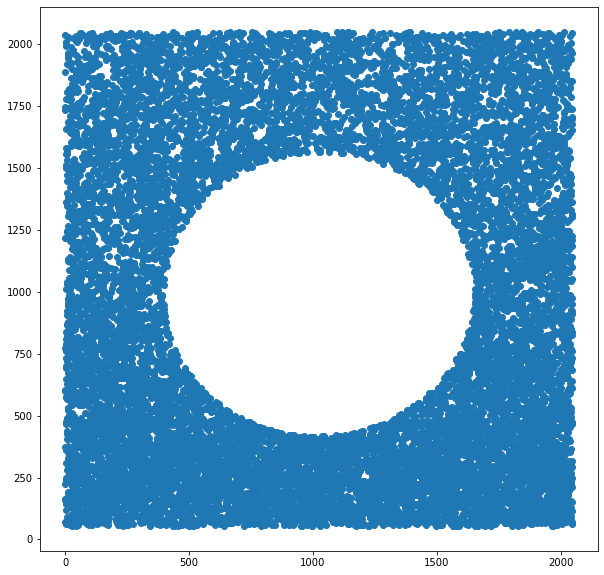

In [718]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full_lr[df_test_full_lr['c'] == 1]['x'], df_test_full_lr[df_test_full_lr['c'] == 1]['y'])

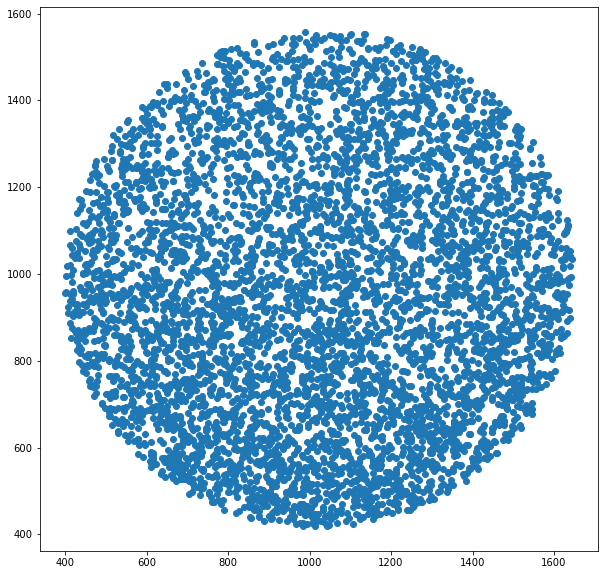

In [719]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full_lr[df_test_full_lr['c'] == 0]['x'], df_test_full_lr[df_test_full_lr['c'] == 0]['y'])

#### XGBoost Classifier

In [692]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline([('column_transformer', column_transformer),
                    ('xgb', XGBClassifier())])

param_grid = {'xgb__n_estimators': [10, 20, 30],
              'xgb__max_depth' : [20, 30],
              'xgb__learning_rate': [0.1, 0.25]
             }

xgb_grid = GridSearchCV(xgb_pipe, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
xgb_grid.fit(df_upd.drop(['c'], axis=1), df_upd['c'])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10, score=-0.110, total=   1.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10, score=-0.110, total=   2.3s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10, score=-0.106, total=   3.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10, score=-0.104, total=   3.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=10, score=-0.132, total=   3.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20, score=-0.108, total=   6.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20, score=-0.107, total=   6.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20, score=-0.104, total=   6.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20, score=-0.103, total=   7.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=20, score=-0.119, total=   7.3s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30, score=-0.107, total=   9.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30, score=-0.106, total=  10.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30, score=-0.105, total=  10.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30, score=-0.102, total=  10.0s
[CV] xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=20, xgb__n_estimators=30, score=-0.113, total=  10.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10, score=-0.110, total=   3.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10, score=-0.110, total=   3.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10, score=-0.106, total=   4.5s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10, score=-0.104, total=   4.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=10, score=-0.132, total=   4.3s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20, score=-0.109, total=   7.3s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20, score=-0.107, total=   7.2s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20, score=-0.104, total=   7.5s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20, score=-0.102, total=   7.4s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=20, score=-0.118, total=  10.8s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:18:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30, score=-0.108, total=  14.3s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:04] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30, score=-0.106, total=  12.6s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30, score=-0.105, total=  11.9s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30, score=-0.101, total=  11.7s
[CV] xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30 .


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.1, xgb__max_depth=30, xgb__n_estimators=30, score=-0.112, total=  14.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10, score=-0.109, total=   3.5s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:19:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10, score=-0.108, total=   4.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10, score=-0.104, total=   4.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:06] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10, score=-0.102, total=   3.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:10] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=10, score=-0.112, total=   3.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20, score=-0.108, total=   6.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20, score=-0.106, total=   7.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20, score=-0.104, total=   7.9s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20, score=-0.101, total=   6.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:42] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=20, score=-0.112, total=   6.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30, score=-0.107, total=  10.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:20:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30, score=-0.105, total=   9.7s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30, score=-0.104, total=  10.3s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30, score=-0.101, total=   9.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=20, xgb__n_estimators=30, score=-0.111, total=  11.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10, score=-0.109, total=   4.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10, score=-0.108, total=   4.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10, score=-0.105, total=   3.9s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10, score=-0.102, total=   3.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:21:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=10, score=-0.112, total=   4.0s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20, score=-0.107, total=   7.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:08] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20, score=-0.105, total=   7.5s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20, score=-0.105, total=   7.4s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:23] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20, score=-0.100, total=   8.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=20, score=-0.111, total=   8.1s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30, score=-0.107, total=  11.5s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:51] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30, score=-0.106, total=  14.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30, score=-0.104, total=  12.2s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30, score=-0.100, total=  13.8s
[CV] xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30 


C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  xgb__learning_rate=0.25, xgb__max_depth=30, xgb__n_estimators=30, score=-0.112, total=  15.2s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.7min finished
C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['x',
                                                                          'y'])])),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                             

In [693]:
print(xgb_grid.best_score_)

-0.10561053488301078


In [694]:
xgb_best = xgb_grid.best_estimator_.fit(df_upd.drop(['c'], axis=1), df_upd['c'])
df_test = pd.read_csv('data/test.csv', index_col='id')
y_test_predict = xgb_best.predict(df_test)
df_test_full = df_test.copy()
df_test_full['c'] = y_test_predict

C:\Users\aabyl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:24:00] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


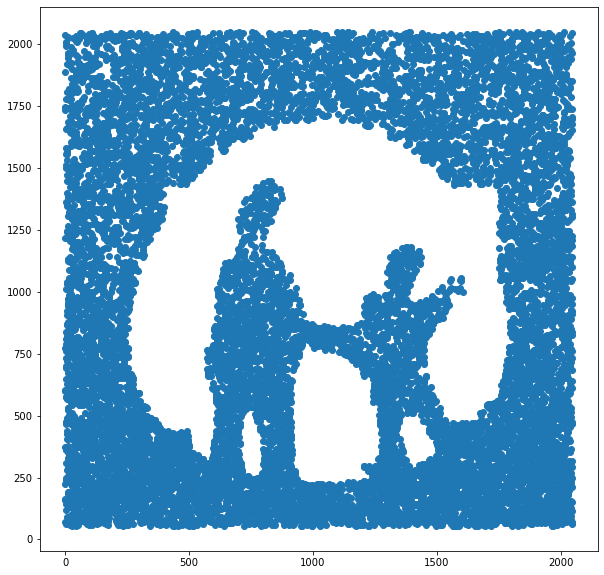

In [695]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 1]['x'], df_test_full[df_test_full['c'] == 1]['y'])

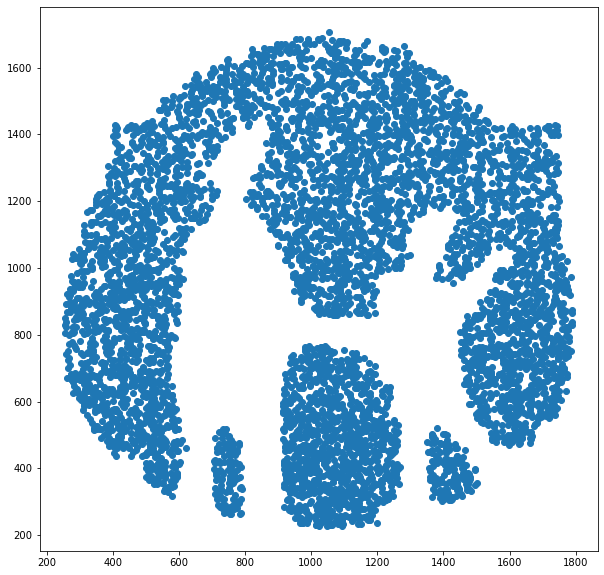

In [696]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 0]['x'], df_test_full[df_test_full['c'] == 0]['y'])

#### LGBM Classifier

In [697]:
from lightgbm import LGBMClassifier

lgbm_pipe = Pipeline([('column_transformer', column_transformer),
                    ('lgbm', LGBMClassifier())])

param_grid = {'lgbm__n_estimators': [30, 50, 100],
              'lgbm__max_depth' : [20, 30, 50],
              'lgbm__learning_rate': [0.1, 0.25]
             }

lgbm_grid = GridSearchCV(lgbm_pipe, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
lgbm_grid.fit(df_upd.drop(['c'], axis=1), df_upd['c'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30, score=-0.166, total=   0.6s
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30, score=-0.167, total=   0.7s
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30, score=-0.162, total=   0.7s
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30 
[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30, score=-0.169, total=   0.6s
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30 
[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=30, score=-0.191, total=   0.7s
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.148, total=   0.9s
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.150, total=   0.9s
[CV] lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.1, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.147, total=   1.0s
[CV] lgbm__learning_rat

[CV]  lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=30, score=-0.163, total=   0.6s
[CV] lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.122, total=   1.0s
[CV] lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.119, total=   1.0s
[CV] lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.119, total=   1.1s
[CV] lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.118, total=   1.3s
[CV] lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50 
[CV]  lgbm__learning_rate=0.25, lgbm__max_depth=20, lgbm__n_estimators=50, score=-0.164, total=   1.3s
[CV] lgbm__l

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['x',
                                                                          'y'])])),
                                       ('lgbm', LGBMClassifier())]),
             param_grid={'lgbm__learning_rate': [0.1, 0.25],
                         'lgbm__max_depth': [20, 30, 50],
                         'lgbm__n_estimators': [30, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [698]:
print(lgbm_grid.best_score_)

-0.12134395672953069


In [699]:
lgbm_best = lgbm_grid.best_estimator_.fit(df_upd.drop(['c'], axis=1), df_upd['c'])
lgbm_test = pd.read_csv('data/test.csv', index_col='id')
y_test_predict = lgbm_best.predict(df_test)
df_test_full = df_test.copy()
df_test_full['c'] = y_test_predict

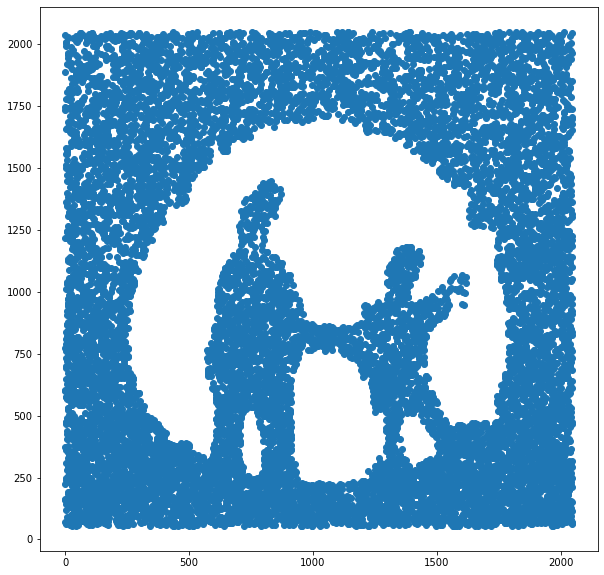

In [700]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 1]['x'], df_test_full[df_test_full['c'] == 1]['y'])

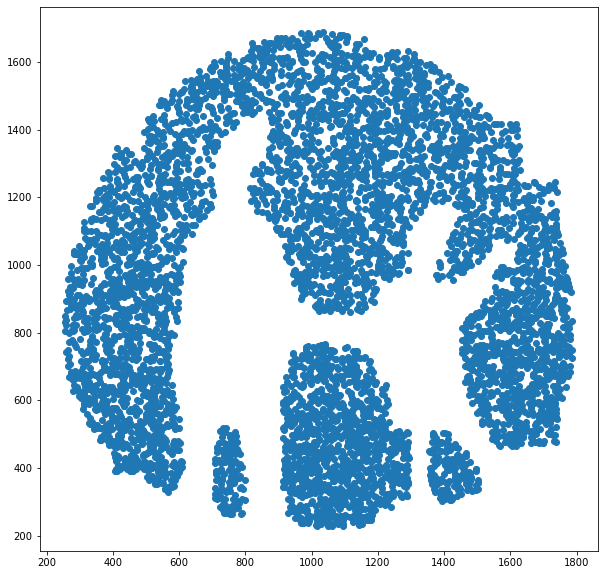

In [701]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 0]['x'], df_test_full[df_test_full['c'] == 0]['y'])

#### CatBoost Classifier

In [702]:
from catboost import CatBoostClassifier

cb_pipe = Pipeline([('column_transformer', column_transformer),
                    ('cb', CatBoostClassifier())])

param_grid = {'cb__n_estimators': [10, 20, 30],
              'cb__max_depth' : [10, 20, 30],
              'cb__learning_rate': [0.1, 0.25]
             }

cb_grid = GridSearchCV(cb_pipe, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
cb_grid.fit(df_upd.drop(['c'], axis=1), df_upd['c'])

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] cb__learning_rate=0.1, cb__max_depth=10, cb__n_estimators=10 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 0.6286734	total: 241ms	remaining: 2.17s
1:	learn: 0.5727673	total: 315ms	remaining: 1.26s
2:	learn: 0.5257651	total: 396ms	remaining: 923ms
3:	learn: 0.4865983	total: 461ms	remaining: 691ms
4:	learn: 0.4510996	total: 529ms	remaining: 529ms
5:	learn: 0.4218227	total: 597ms	remaining: 398ms
6:	learn: 0.3961915	total: 660ms	remaining: 283ms
7:	learn: 0.3727934	total: 732ms	remaining: 183ms
8:	learn: 0.3526955	total: 798ms	remaining: 88.7ms
9:	learn: 0.3341477	total: 877ms	remaining: 0us
[CV]  cb__learning_rate=0.1, cb__max_depth=10, cb__n_estimators=10, score=-0.293, total=   1.3s
[CV] cb__learning_rate=0.1, cb__max_depth=10, cb__n_estimators=10 ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


0:	learn: 0.6283287	total: 72.1ms	remaining: 648ms
1:	learn: 0.5725494	total: 142ms	remaining: 567ms
2:	learn: 0.5260170	total: 222ms	remaining: 518ms
3:	learn: 0.4873141	total: 322ms	remaining: 483ms
4:	learn: 0.4534322	total: 392ms	remaining: 392ms
5:	learn: 0.4228145	total: 460ms	remaining: 307ms
6:	learn: 0.3965514	total: 530ms	remaining: 227ms
7:	learn: 0.3731918	total: 607ms	remaining: 152ms
8:	learn: 0.3527309	total: 677ms	remaining: 75.3ms
9:	learn: 0.3340328	total: 757ms	remaining: 0us
[CV]  cb__learning_rate=0.1, cb__max_depth=10, cb__n_estimators=10, score=-0.308, total=   1.1s
[CV] cb__learning_rate=0.1, cb__max_depth=10, cb__n_estimators=10 ....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


0:	learn: 0.6283620	total: 68.8ms	remaining: 619ms
1:	learn: 0.5725186	total: 135ms	remaining: 539ms
2:	learn: 0.5261025	total: 199ms	remaining: 465ms
3:	learn: 0.4870436	total: 265ms	remaining: 398ms
4:	learn: 0.4527137	total: 337ms	remaining: 337ms
5:	learn: 0.4220831	total: 402ms	remaining: 268ms
6:	learn: 0.3962910	total: 468ms	remaining: 201ms
7:	learn: 0.3734132	total: 545ms	remaining: 136ms
8:	learn: 0.3531644	total: 618ms	remaining: 68.6ms
9:	learn: 0.3336907	total: 693ms	remaining: 0us
[CV]  cb__learning_rate=0.1, cb__max_depth=10, cb__n_estimators=10, score=-0.295, total=   1.0s
[CV] cb__learning_rate=0.1, cb__max_depth=10, cb__n_estimators=10 ....
0:	learn: 0.6280786	total: 74.1ms	remaining: 667ms
1:	learn: 0.5720883	total: 149ms	remaining: 596ms
2:	learn: 0.5255512	total: 216ms	remaining: 503ms
3:	learn: 0.4867198	total: 283ms	remaining: 424ms
4:	learn: 0.4533579	total: 358ms	remaining: 358ms
5:	learn: 0.4228425	total: 437ms	remaining: 292ms
6:	learn: 0.3961870	total: 519ms

9:	learn: 0.3341477	total: 719ms	remaining: 1.44s
10:	learn: 0.3179831	total: 789ms	remaining: 1.36s
11:	learn: 0.3025537	total: 855ms	remaining: 1.28s
12:	learn: 0.2889864	total: 920ms	remaining: 1.2s
13:	learn: 0.2757997	total: 996ms	remaining: 1.14s
14:	learn: 0.2649304	total: 1.07s	remaining: 1.07s
15:	learn: 0.2531778	total: 1.15s	remaining: 1.01s
16:	learn: 0.2429994	total: 1.24s	remaining: 945ms
17:	learn: 0.2344324	total: 1.31s	remaining: 874ms
18:	learn: 0.2267493	total: 1.38s	remaining: 801ms
19:	learn: 0.2185532	total: 1.45s	remaining: 726ms
20:	learn: 0.2118493	total: 1.52s	remaining: 650ms
21:	learn: 0.2052172	total: 1.58s	remaining: 574ms
22:	learn: 0.1993896	total: 1.64s	remaining: 501ms
23:	learn: 0.1927890	total: 1.71s	remaining: 427ms
24:	learn: 0.1881911	total: 1.77s	remaining: 354ms
25:	learn: 0.1825435	total: 1.84s	remaining: 284ms
26:	learn: 0.1782542	total: 1.91s	remaining: 212ms
27:	learn: 0.1736792	total: 1.97s	remaining: 141ms
28:	learn: 0.1695761	total: 2.04s

C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=10 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=10 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=10 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30 ....


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30 ....
[CV]  cb__learning_rate=0.1, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=10, cb__n_estimators=10 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

0:	learn: 0.5444951	total: 52.6ms	remaining: 474ms
1:	learn: 0.4463633	total: 104ms	remaining: 417ms
2:	learn: 0.3763409	total: 154ms	remaining: 359ms
3:	learn: 0.3256602	total: 207ms	remaining: 310ms
4:	learn: 0.2883935	total: 262ms	remaining: 262ms
5:	learn: 0.2588931	total: 319ms	remaining: 213ms
6:	learn: 0.2371736	total: 380ms	remaining: 163ms
7:	learn: 0.2146385	total: 438ms	remaining: 110ms
8:	learn: 0.1978610	total: 502ms	remaining: 55.7ms
9:	learn: 0.1840863	total: 558ms	remaining: 0us
[CV]  cb__learning_rate=0.25, cb__max_depth=10, cb__n_estimators=10, score=-0.258, total=   0.8s
[CV] cb__learning_rate=0.25, cb__max_depth=10, cb__n_estimators=10 ...
0:	learn: 0.5437062	total: 54ms	remaining: 486ms
1:	learn: 0.4459911	total: 110ms	remaining: 439ms
2:	learn: 0.3755337	total: 170ms	remaining: 397ms
3:	learn: 0.3270378	total: 226ms	remaining: 340ms
4:	learn: 0.2889311	total: 288ms	remaining: 288ms
5:	learn: 0.2583103	total: 346ms	remaining: 231ms
6:	learn: 0.2332727	total: 403ms	

4:	learn: 0.3007330	total: 302ms	remaining: 905ms
5:	learn: 0.2737345	total: 362ms	remaining: 846ms
6:	learn: 0.2479695	total: 430ms	remaining: 799ms
7:	learn: 0.2287271	total: 552ms	remaining: 829ms
8:	learn: 0.2127004	total: 630ms	remaining: 770ms
9:	learn: 0.1988146	total: 701ms	remaining: 701ms
10:	learn: 0.1869828	total: 778ms	remaining: 637ms
11:	learn: 0.1745872	total: 857ms	remaining: 572ms
12:	learn: 0.1637734	total: 939ms	remaining: 506ms
13:	learn: 0.1550666	total: 1.01s	remaining: 435ms
14:	learn: 0.1485904	total: 1.1s	remaining: 366ms
15:	learn: 0.1417670	total: 1.18s	remaining: 294ms
16:	learn: 0.1356050	total: 1.25s	remaining: 220ms
17:	learn: 0.1309846	total: 1.33s	remaining: 147ms
18:	learn: 0.1269529	total: 1.39s	remaining: 73.4ms
19:	learn: 0.1215287	total: 1.46s	remaining: 0us
[CV]  cb__learning_rate=0.25, cb__max_depth=10, cb__n_estimators=20, score=-0.153, total=   1.8s
[CV] cb__learning_rate=0.25, cb__max_depth=10, cb__n_estimators=30 ...
0:	learn: 0.5444951	tota

10:	learn: 0.1869828	total: 671ms	remaining: 1.16s
11:	learn: 0.1745872	total: 741ms	remaining: 1.11s
12:	learn: 0.1637734	total: 806ms	remaining: 1.05s
13:	learn: 0.1550666	total: 869ms	remaining: 993ms
14:	learn: 0.1485904	total: 937ms	remaining: 937ms
15:	learn: 0.1417670	total: 1s	remaining: 877ms
16:	learn: 0.1356050	total: 1.07s	remaining: 819ms
17:	learn: 0.1309846	total: 1.15s	remaining: 766ms
18:	learn: 0.1269529	total: 1.23s	remaining: 711ms
19:	learn: 0.1215287	total: 1.3s	remaining: 651ms
20:	learn: 0.1174431	total: 1.37s	remaining: 587ms
21:	learn: 0.1138878	total: 1.45s	remaining: 526ms
22:	learn: 0.1103607	total: 1.53s	remaining: 467ms
23:	learn: 0.1076090	total: 1.62s	remaining: 404ms
24:	learn: 0.1044371	total: 1.69s	remaining: 338ms
25:	learn: 0.1020597	total: 1.76s	remaining: 271ms
26:	learn: 0.0998845	total: 1.83s	remaining: 203ms
27:	learn: 0.0975325	total: 1.9s	remaining: 136ms
28:	learn: 0.0959626	total: 1.96s	remaining: 67.7ms
29:	learn: 0.0939765	total: 2.04s	r

C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=20, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=10, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=20, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30 ...


C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\core.py", line 1981, in _fit
    train_params = self._prepare_train_params(
  File "C:\Users\aabyl\anaconda3\lib\site-packages\catboost\cor

[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
[CV] cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30 ...
[CV]  cb__learning_rate=0.25, cb__max_depth=30, cb__n_estimators=30, score=nan, total=   0.1s
0:	learn: 0.5396420	total: 63.5ms	remaining: 1.84s
1:	learn: 0.4442351	total: 128ms	remaining: 1.8s
2:	learn: 0.3753811	total: 196ms	remaining: 1.77s
3:	learn: 0.3261142	total: 282ms	remaining: 1.83s
4:	learn: 0.2900164	total: 353ms	remaining: 1.76s
5:	learn: 0.2588682	total: 420ms	remaining: 1.68s
6:	learn: 0.2359361	total: 501ms	remaining: 1.64s
7:	learn: 0.2148401	total: 585ms	remaining: 1.61s
8:	learn: 0.1989670	total: 657ms	remaining: 1.53s
9:	learn: 0.1853140	total: 736ms	remaining: 1.47s
10:	learn: 0.1725275	total: 815ms	remaining: 1.41s
11:	learn: 0.1633939	tota

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['x',
                                                                          'y'])])),
                                       ('cb',
                                        <catboost.core.CatBoostClassifier object at 0x0000026933136460>)]),
             param_grid={'cb__learning_rate': [0.1, 0.25],
                         'cb__max_depth': [10, 20, 30],
                         'cb__n_estimators': [10, 20, 30]},
             scoring='neg_root_mean_squar

In [703]:
print(cb_grid.best_score_)

-0.16507661006690194


In [704]:
cb_best = cb_grid.best_estimator_.fit(df_upd.drop(['c'], axis=1), df_upd['c'])
cb_test = pd.read_csv('data/test.csv', index_col='id')
y_test_predict = cb_best.predict(df_test)
df_test_full = df_test.copy()
df_test_full['c'] = y_test_predict

0:	learn: 0.5396420	total: 73.5ms	remaining: 2.13s
1:	learn: 0.4442351	total: 140ms	remaining: 1.95s
2:	learn: 0.3753811	total: 204ms	remaining: 1.84s
3:	learn: 0.3261142	total: 269ms	remaining: 1.75s
4:	learn: 0.2900164	total: 339ms	remaining: 1.69s
5:	learn: 0.2588682	total: 406ms	remaining: 1.62s
6:	learn: 0.2359361	total: 476ms	remaining: 1.56s
7:	learn: 0.2148401	total: 550ms	remaining: 1.51s
8:	learn: 0.1989670	total: 622ms	remaining: 1.45s
9:	learn: 0.1853140	total: 697ms	remaining: 1.39s
10:	learn: 0.1725275	total: 772ms	remaining: 1.33s
11:	learn: 0.1633939	total: 852ms	remaining: 1.28s
12:	learn: 0.1552008	total: 929ms	remaining: 1.21s
13:	learn: 0.1480687	total: 1.01s	remaining: 1.15s
14:	learn: 0.1414105	total: 1.08s	remaining: 1.08s
15:	learn: 0.1343117	total: 1.16s	remaining: 1.01s
16:	learn: 0.1289362	total: 1.23s	remaining: 942ms
17:	learn: 0.1226983	total: 1.31s	remaining: 871ms
18:	learn: 0.1179639	total: 1.39s	remaining: 803ms
19:	learn: 0.1139244	total: 1.47s	remain

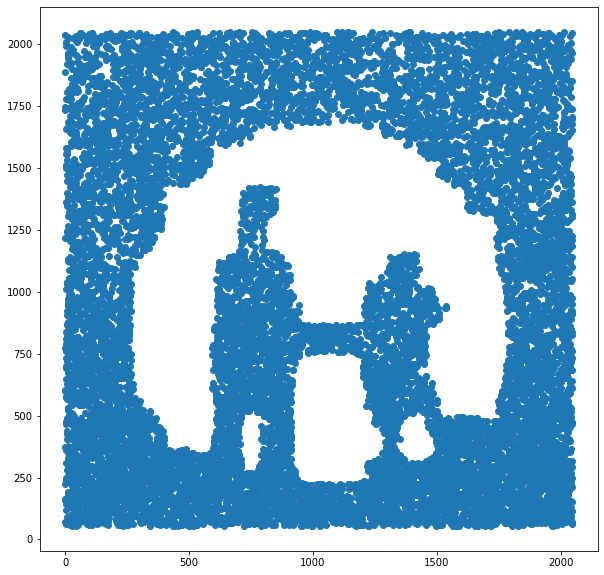

In [705]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 1]['x'], df_test_full[df_test_full['c'] == 1]['y'])

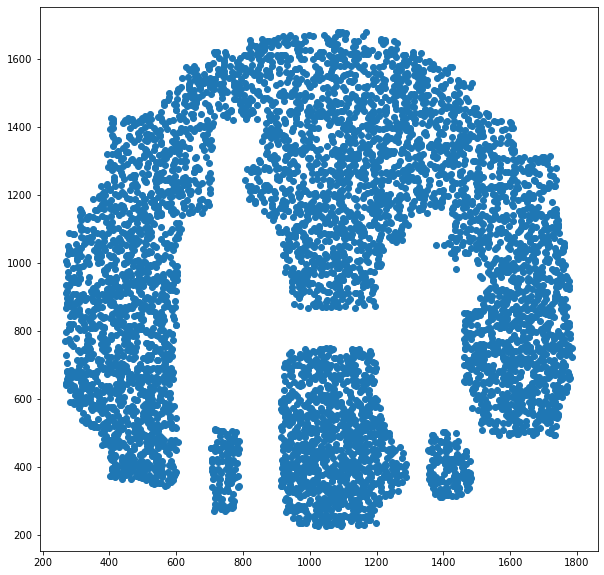

In [706]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 0]['x'], df_test_full[df_test_full['c'] == 0]['y'])

#### Random Forest Classifier

In [709]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('column_transformer', column_transformer),
                    ('rf', RandomForestClassifier())])

param_grid = {'rf__n_estimators': [10, 20, 30],
              'rf__max_depth' : [10, 20, 30],
              'rf__min_samples_leaf': [1, 3, 5]
             }

rf_grid = GridSearchCV(rf_pipe, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)
rf_grid.fit(df_upd.drop(['c'], axis=1), df_upd['c'])

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10 ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10, score=-0.245, total=   2.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10 ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10, score=-0.217, total=   2.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10 ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10, score=-0.205, total=   2.3s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10 ...
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10, score=-0.186, total=   2.4s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10 ...
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=10, score=-0.345, total=   2.5s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=20 ...
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=20, score=-0.188, total=   5.0s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=20 ...
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=20, score=-0.193, total=   6.2s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=20 ...
[CV]  rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=20, score=-0.198, total=   5.1s
[CV] rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators

[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=20, score=-0.103, total=   6.2s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=20 ...
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=20, score=-0.103, total=   6.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=20 ...
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=20, score=-0.101, total=   6.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=20 ...
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=20, score=-0.120, total=   6.4s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=30 ...
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=30, score=-0.104, total=   9.3s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=30 ...
[CV]  rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators=30, score=-0.104, total=   9.0s
[CV] rf__max_depth=20, rf__min_samples_leaf=1, rf__n_estimators

[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30, score=-0.106, total=  10.0s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30 ...
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30, score=-0.103, total=   8.9s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30 ...
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30, score=-0.103, total=   8.8s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30 ...
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30, score=-0.100, total=  10.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30 ...
[CV]  rf__max_depth=30, rf__min_samples_leaf=1, rf__n_estimators=30, score=-0.125, total=  10.6s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__n_estimators=10 ...
[CV]  rf__max_depth=30, rf__min_samples_leaf=3, rf__n_estimators=10, score=-0.108, total=   3.1s
[CV] rf__max_depth=30, rf__min_samples_leaf=3, rf__n_estimators

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 14.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaling',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['x',
                                                                          'y'])])),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [10, 20, 30],
                         'rf__min_samples_leaf': [1, 3, 5],
                         'rf__n_estimators': [10, 20, 30]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [710]:
print(rf_grid.best_score_)

-0.10636638081935006


In [711]:
rf_best = rf_grid.best_estimator_.fit(df_upd.drop(['c'], axis=1), df_upd['c'])
rf_test = pd.read_csv('data/test.csv', index_col='id')
y_test_predict = rf_best.predict(df_test)
df_test_full = df_test.copy()
df_test_full['c'] = y_test_predict

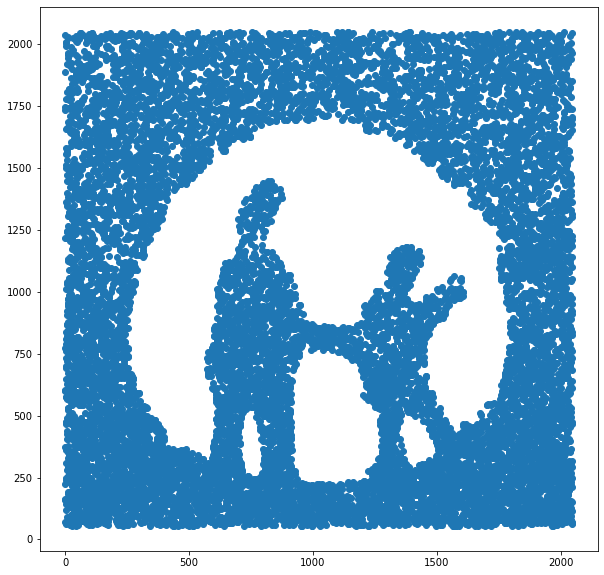

In [712]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 1]['x'], df_test_full[df_test_full['c'] == 1]['y'])

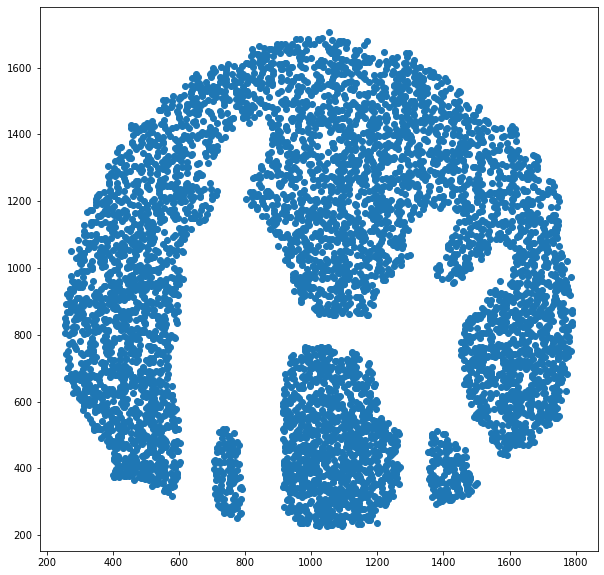

In [713]:
plt.figure(figsize=[10,10])
plt.scatter(df_test_full[df_test_full['c'] == 0]['x'], df_test_full[df_test_full['c'] == 0]['y'])

In [733]:
y_knn = knn_best.predict(df_upd.drop(['c'], axis=1))
y_xgb = xgb_best.predict(df_upd.drop(['c'], axis=1))
y_lgbm = lgbm_best.predict(df_upd.drop(['c'], axis=1))
y_cb = cb_best.predict(df_upd.drop(['c'], axis=1))
y_rf = rf_best.predict(df_upd.drop(['c'], axis=1))

last_error = 0.2


for i1 in range(0, 100, 10):
    for i2 in range(0, 100, 10):
        for i3 in range(0, 100, 10):
            for i4 in range(0, 100, 10):
                for i5 in range(0, 100, 10):
                    if i1 + i2 + i3 + i4 + i5 == 100:
                        y_pred = (y_knn * i1 + y_xgb * i1 + y_lgbm * i3 + y_cb * i4 + y_rf * i5) / 500
                        y_pred = np.rint(y_pred)
                        current_error = np.sqrt(mean_squared_error(df_upd['c'], y_pred))
                        if current_error < last_error:
                            model_weights = [i1, i2, i3, i4, i5]
                            last_error = current_error
                            print(last_error)
                            
print(model_weights)
print(last_error)

[40, 40, 0, 0, 20]
0.2


In [734]:
final_test = pd.read_csv('data/test.csv', index_col='id')
y_test_predict = cb_best.predict(final_test)

y_knn = knn_best.predict(final_test)
y_xgb = xgb_best.predict(final_test)
y_lgbm = lgbm_best.predict(final_test)
y_cb = cb_best.predict(final_test)
y_rf = rf_best.predict(final_test)

y_pred = (y_knn * i1 + y_xgb * i1 + y_lgbm * i3 + y_cb * i4 + y_rf * i5) / 500
y_pred = np.rint(y_pred)

final_test_full = final_test.copy()
final_test_full['c'] = y_pred

In [735]:
y_test_predict = pd.Series(final_test_full['c'])
sub_pred = pd.DataFrame()
sub_pred['id'] = y_test_predict.index
sub_pred['c'] = y_test_predict.values.astype('int')
sub_pred.index = sub_pred['id']
sub_pred.drop(columns=['id'], inplace=True)
sub_pred.to_csv('kaspi_preds.csv')

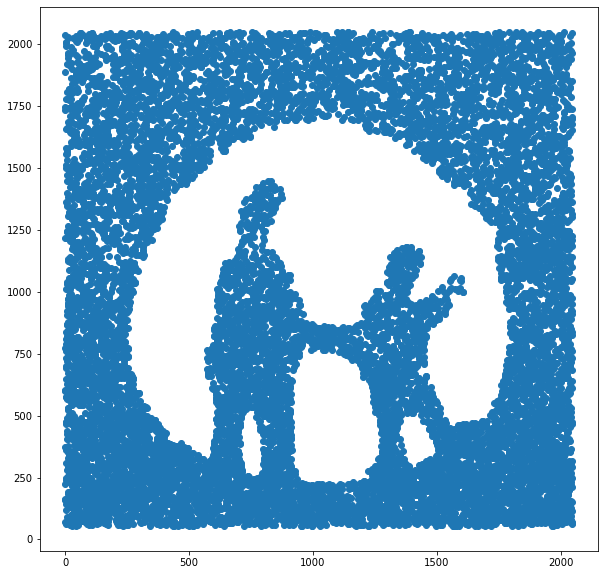

In [736]:
plt.figure(figsize=[10,10])
plt.scatter(final_test_full[final_test_full['c'] == 1]['x'], final_test_full[final_test_full['c'] == 1]['y'])